<a href="https://colab.research.google.com/github/sznajder/Lectures/blob/master/MLP_VBFHZZ_TFKeras_sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP with sigmoid output for VBF HZZ4l analysis using  Keras
Author: Andre Sznajder

## **Mount Google Drive**

In [1]:
!fusermount -u drive
!pip install uproot
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/"
data_dir = "/content/gdrive/My Drive/Colab Notebooks/Data/"
!ls {data_dir}

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/gdrive
ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/Colab': No such file or directory
ls: cannot access 'Notebooks/Data/': No such file or directory


#Load data using PANDAS data frames#
Now we load two different `NumPy` arrays. One corresponding to the VBF H->ZZ->4l signal and the other one corresponds to the full set of backgrounds .

In [2]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

filename = {}
upfile = {}
data = {}
df = {}


#data_dir = '/Users/sznajder/Google Drive/Colab Notebooks/Data/'
filename['sig'] = data_dir+'VBFHZZ_signal.csv'
filename['bkg'] = data_dir+'VBFHZZ_background.csv'

# Variables from Roottree to be copyed to PANDA dataframe

VARS = [ 'proc', 'f_run', 'f_event', 'f_weight', \
        'f_massjj', 'f_deltajj', 'f_mass4l', 'f_Z1mass' , 'f_Z2mass', \
        'f_lept1_pdgid', 'f_lept2_pdgid', 'f_lept3_pdgid', 'f_lept4_pdgid', \
        'f_lept1_pt','f_lept1_eta','f_lept1_phi', \
        'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
        'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
        'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
        'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
        'f_jet2_pt','f_jet2_eta','f_jet2_phi', \
        'f_jet3_pt','f_jet3_eta','f_jet3_phi' ]
        
# Read CSV signal and background files into pandas Dataframe
df['sig']  = pd.read_csv(filename['sig'])
df['bkg']  = pd.read_csv(filename['bkg'])
df['sig'].columns = VARS
df['bkg'].columns = VARS

# Crop the background sample to have the same number of events as the signal sample
#df['bkg']=df['bkg'][:len(df['sig'])]

print(len(df['sig']))
print(len(df['bkg']))

# Remove undefined variable entries VARS[i] <= -999
#for i in range(len(VARS)): 
#  df['sig'] = df['sig'][(df['sig'][VARS[i]] > -999)]
#  df['bkg'] = df['bkg'][(df['bkg'][VARS[i]] > -999)]


28953
69596


**Prepare data for NN input**

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Add the variable isSignal to the dataframe containing the signal and background events
df['sig']['isSignal']=  np.ones(len(df['sig'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

print("Number SIG events=", len(df['sig']))
print("Number BKG events=", len(df['bkg']))

# Renormalizes the events weights to give unit sum in the signal and background dataframes
# This is necessary for the NN to learn signal and background in the same proportion , 
#   independently of number of events and absolute weights of events in each sample !
df['sig']['f_weight']=df['sig']['f_weight']/df['sig']['f_weight'].sum(axis=0)
df['bkg']['f_weight']=df['bkg']['f_weight']/df['bkg']['f_weight'].sum(axis=0)


# Concatenate the signal and background in a single  data frames 
df_all = pd.concat([df['sig'],df['bkg']])

# Random shuffles the dataset to mix signal and background events before splitting between train and test samples
df_all = shuffle(df_all)

# Filter dataframe leaving just NN input variables  
#NN_VARS = [ 'f_massjj', 'f_deltajj', 'f_Z2mass', \
NN_VARS = [ 'f_lept1_pdgid', 'f_lept2_pdgid', 'f_lept3_pdgid', 'f_lept4_pdgid', \
            'f_lept1_pt','f_lept1_eta','f_lept1_phi', \
            'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
            'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
            'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
            'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
            'f_jet2_pt','f_jet2_eta','f_jet2_phi']
         
df_input  = df_all.filter(NN_VARS)
df_target = df_all.filter(['isSignal'])
df_weights = df_all.filter(['f_weight'])

# Transform dataframes to numpy arrays of float32 (. X->NN input , Y->NN target output , W-> event weights)
NINPUT=len(NN_VARS)
print("Number NN input variables=",NINPUT)
print("NN input variables=",NN_VARS)
X  = np.asarray( df_input.values ).astype(np.float32)
Y  = np.asarray( df_target.values ).astype(np.float32)
W  = np.asarray( df_weights.values ).astype(np.float32)

# Split the sample into train and test  
X_train_val, X_test, Y_train_val, Y_test , W_train_val , W_test = train_test_split(X, Y, W , test_size=0.2, shuffle=True)


#for i in range(20): print("X_train_val=",X_train_val[i])
#for i in range(20): print("Y_train_val=",Y_train_val[i])
#for i in range(20): print("w_train_val=",W_train_val[i])


Number SIG events= 28953
Number BKG events= 69596
Number NN input variables= 22
NN input variables= ['f_lept1_pdgid', 'f_lept2_pdgid', 'f_lept3_pdgid', 'f_lept4_pdgid', 'f_lept1_pt', 'f_lept1_eta', 'f_lept1_phi', 'f_lept2_pt', 'f_lept2_eta', 'f_lept2_phi', 'f_lept3_pt', 'f_lept3_eta', 'f_lept3_phi', 'f_lept4_pt', 'f_lept4_eta', 'f_lept4_phi', 'f_jet1_pt', 'f_jet1_eta', 'f_jet1_phi', 'f_jet2_pt', 'f_jet2_eta', 'f_jet2_phi']


## Define the model using KERAS functional API 
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The output layer contains a single neuron using a sigmoid activation in order to a number between 0 and 1 to make binary classification

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [4]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout
from tensorflow.keras import utils

# Define NN layers
input  = Input(shape=(NINPUT,), name = 'input') 
hidden = Dense(NINPUT*30 , name = 'hidden', kernel_initializer='normal', activation='relu')(input)
#hidden = Dropout(rate=0.1)(hidden)
output  = Dense(1      , name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)
#hidden1 = Dense(NINPUT*2  , name = 'hidden1', kernel_initializer='normal', activation='relu')(input)
#hidden1 = Dropout(rate=0.2)(hidden1)
#hidden2 = Dense(int(NINPUT)  , name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden1)
#hidden2 = Dropout(rate=0.2)(hidden2)
#hidden3 = Dense(int(NINPUT/2)  , name = 'hidden3', kernel_initializer='normal', activation='relu')(hidden2)
#hidden3 = Dropout(rate=0.2)(hidden3)
#output  = Dense(1      , name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden3)

# create the model
model = Model(inputs=input, outputs=output)
# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.01,decay=1e-6)
optim = Adam()
# compile the model
#model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'], weighted_metrics=['accuracy'])
#model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
# print the model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 22)]              0         
_________________________________________________________________
hidden (Dense)               (None, 660)               15180     
_________________________________________________________________
output (Dense)               (None, 1)                 661       
Total params: 15,841
Trainable params: 15,841
Non-trainable params: 0
_________________________________________________________________


## Prepare DATA by dividing into testing and training dataset and renormalizing events weights

We will split the data into two parts (one for training+validation and one for testing). 


## Run NN Training 


In [5]:
# Number of training epochs
nepochs=1000
# Batch size
batch=500
# Train classifier
history = model.fit(X_train_val, 
                    Y_train_val,
                    epochs=nepochs, 
                    sample_weight=W_train_val,
                    batch_size=batch, 
                    verbose=1, # switch to 1 for more verbosity 
                    validation_split=0.3)


Epoch 1/1000
111/111 [==============================] - 2s 20ms/step - loss: 2.1264e-05 - accuracy: 0.5403 - weighted_accuracy: 0.5632 - val_loss: 1.4103e-05 - val_accuracy: 0.6677 - val_weighted_accuracy: 0.5572
Epoch 2/1000
111/111 [==============================] - 2s 19ms/step - loss: 1.3801e-05 - accuracy: 0.5665 - weighted_accuracy: 0.5979 - val_loss: 1.4982e-05 - val_accuracy: 0.6876 - val_weighted_accuracy: 0.5399
Epoch 3/1000
111/111 [==============================] - 2s 19ms/step - loss: 1.3580e-05 - accuracy: 0.5728 - weighted_accuracy: 0.6031 - val_loss: 1.4020e-05 - val_accuracy: 0.5014 - val_weighted_accuracy: 0.5917
Epoch 4/1000
111/111 [==============================] - 2s 19ms/step - loss: 1.3620e-05 - accuracy: 0.5765 - weighted_accuracy: 0.6060 - val_loss: 1.4657e-05 - val_accuracy: 0.4199 - val_weighted_accuracy: 0.5865
Epoch 5/1000
111/111 [==============================] - 2s 19ms/step - loss: 1.3070e-05 - accuracy: 0.6002 - weighted_accuracy: 0.6377 - val_loss: 1

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

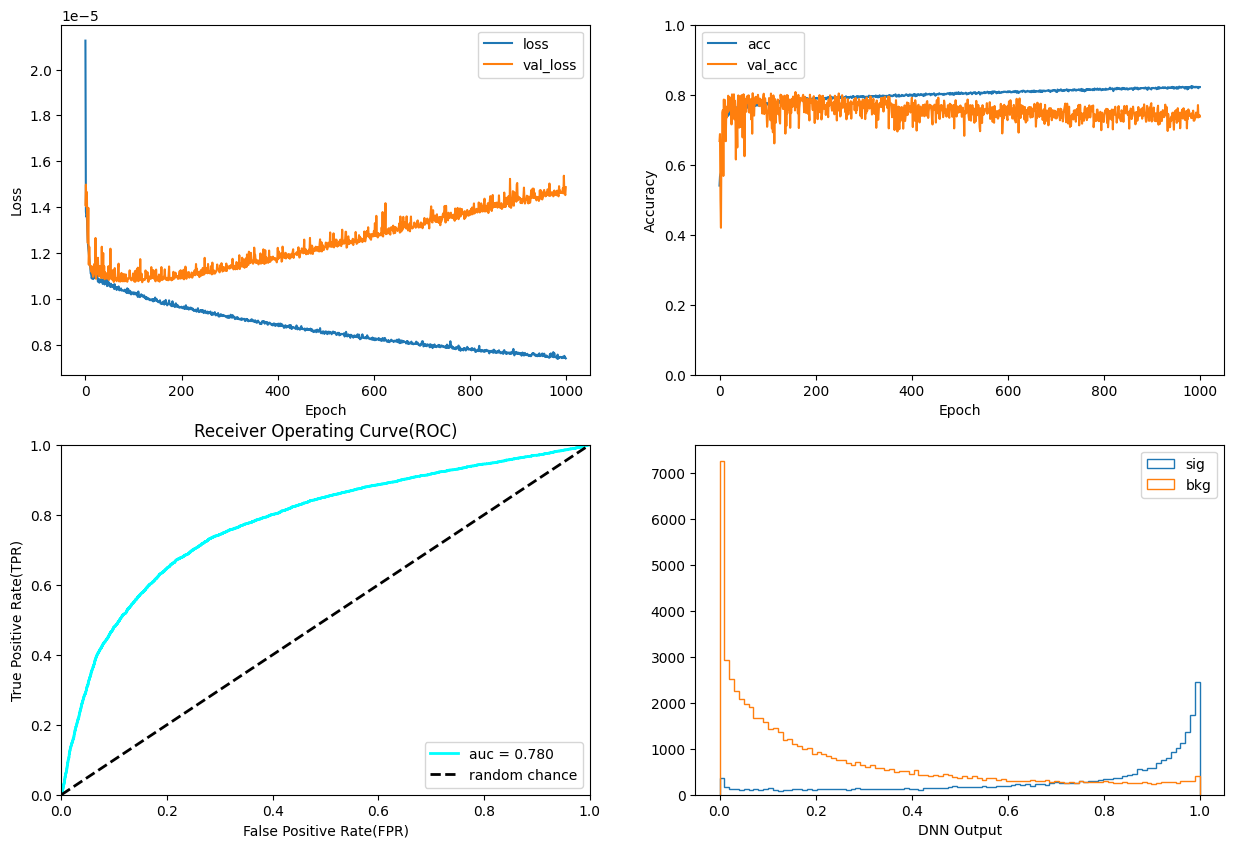

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
plt.figure(figsize=(15,10))

# plot loss vs epoch
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
#ax.set_ylim([0, 1])
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['accuracy'], label='acc')
ax.plot(history.history['val_accuracy'], label='val_acc')
ax.set_ylim([0, 1.0])
ax.legend(loc="upper left")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Plot ROC
Y_predict = model.predict(X_test[:,0:NINPUT])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate(FPR)')
ax.set_ylabel('True Positive Rate(TPR)')
ax.set_title('Receiver Operating Curve(ROC)')
ax.legend(loc="lower right")

# Plot DNN output 
df_sig  = df['sig'].filter(NN_VARS)
df_bkg  = df['bkg'].filter(NN_VARS)

X_sig  = np.asarray( df_sig.values ).astype(np.float32)
X_bkg  = np.asarray( df_bkg.values ).astype(np.float32)

Y_sig = model.predict(X_sig)
Y_bkg = model.predict(X_bkg)

ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 100)
hist_sig = ax.hist(Y_sig, bins=X, label='sig',histtype='step')
hist_bkg = ax.hist(Y_bkg, bins=X, label='bkg',histtype='step',)

#ax.hist(Y_train_val, bins=X, label='bkg',histtype='step')

ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
plt.show()


# Plot  $m_{jj}$, $\eta_{j}$ and $m_{4l}$  for NN output > cut to show that the NN did learned the physics !


0.7770870030739474
0.6962108731466228


(-5.0, 5.0)

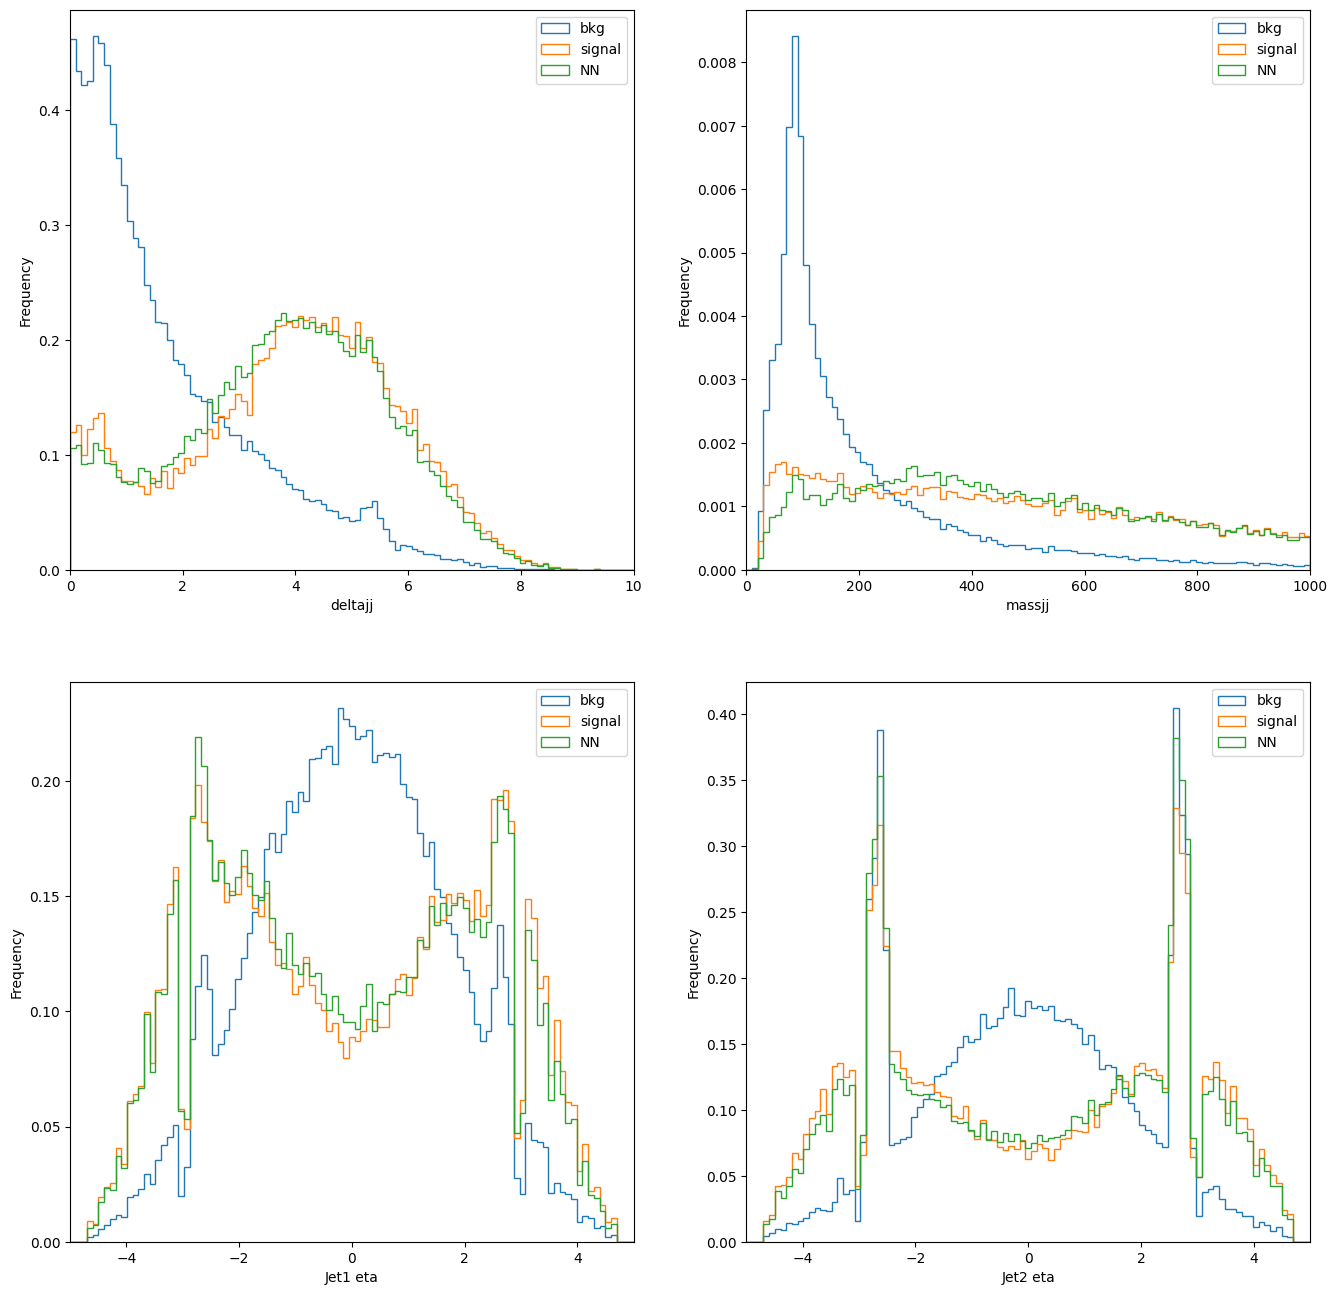

In [7]:

import matplotlib.pyplot as plt

# Define the data frame of high level variables and NN output
data = df_all.filter(NN_VARS)
X_all   = np.asarray( data.values ).astype(np.float32)
Y_all = model.predict(X_all)

# Add the NN prediction array ( Y_all ) column to the complete dataframe
df_all['NNoutput'] = Y_all

# Selects events with NNoutput > cut
cut = 0.5 
df_sel   = df_all[(df_all['NNoutput'] >= cut)]
df_TP    = df_all[(df_all['NNoutput'] >= cut) & (df_all['isSignal'] == 1)]
df_unsel = df_all[(df_all['NNoutput'] < cut)]
df_TN    = df_all[(df_all['NNoutput'] < cut) & (df_all['isSignal'] == 0)]

TP = len(df_TP)
FP = len(df_sel) - TP
TN = len(df_TN)
FN = len(df_unsel) - TN

truepositiverate = float(TP)/(TP+FN)
fakepositiverate = float(FP)/(FP+FN)
print(truepositiverate)
print(fakepositiverate)
    
# Plot high level variables for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 16),dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel('deltajj')
X = np.linspace(0.0,10.,100)
df_all['f_deltajj'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_deltajj'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_deltajj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,10)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(2, 2, 2)
plt.xlabel('massjj')
X = np.linspace(0.0,1000.,100)
df_all['f_massjj'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_massjj'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_massjj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,1000)


# Plot Jet1 eta for signal, background and NN selected events 
plt.subplot(2, 2, 3)
plt.xlabel('Jet1 eta')
X = np.linspace(-5.,5.,100)
df_all['f_jet1_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_jet1_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_jet1_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-5,5)

# Plot Jet2 eta for signal, background and NN selected events 
plt.subplot(2, 2, 4)
plt.xlabel('Jet2 eta')
X = np.linspace(-5.,5.,100)
df_all['f_jet2_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_jet2_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_jet2_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(-5,5)

